
# Q learning (Q-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    #     print('state, action, reward, done, info')
    #     print(state, action, reward, done, info)
    if done:
    #         print('state, action, reward, done, info')
    #         print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Current actions given
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Qs = qs+ (gamma * nextQs)/values/logits: using next_states and dones/end-of-episodes
    nextQs = tf.placeholder(tf.float32, [None], name='nextQs')
    
    # returning the given data to the model
    return states, actions, nextQs

In [7]:
# Q: Qfunction/Encoder/Classifier
def qfunction(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('qfunction', reuse=reuse):        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [8]:
def model_loss(states, actions, # model input data for Qs/qs/rs 
               nextQs, gamma, # model input data for targetQs
               action_size, hidden_size): # model init for Qs
    # Calculating Qs total rewards
    actions_logits = qfunction(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_mask = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_masked = tf.multiply(actions_logits, actions_mask)
    Qs = tf.reduce_max(Qs_masked, axis=1)
    
    # Current reward or Rt/rt
    # Calculating rewards/Rs as prob/sigmoid of Qs, i.e. between 0-1
    qs = tf.sigmoid(Qs) # qt
    
    # Bellman equaion for calculating total rewards using current reward + total future rewards/nextQs
    #targetQs = qs + (0.99 * nextQs)
    targetQs = qs + (gamma * nextQs)
    
    # Calculating the loss: logits/predictions vs labels
    q_loss = tf.reduce_mean(tf.square(Qs - targetQs))

    return actions_logits, q_loss, qs, Qs

In [9]:
def model_opt(q_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Qfunction/Value loss Tensor for next action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)

    return q_opt

In [10]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.nextQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_loss, self.qs, self.Qs = model_loss(
            action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init parameters
            states=self.states, actions=self.actions, nextQs=self.nextQs) # model input data

        # Update the model: backward pass and backprop
        self.q_opt = model_opt(q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [11]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [12]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [13]:
train_episodes = 2000          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [14]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate, 
             gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [16]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
prev_action = env.action_space.sample() # At-1
state, reward, done, info = env.step(prev_action) # St, Rt/Et (Epiosde)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()# At
    next_state, reward, done, info = env.step(action) #St+1

    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        
        # Print out reward and done and check if they are the same: They are NOT.
        #print('if done is true:', reward, done)
        
        # # the episode ends so no next state
        # next_state = np.zeros(state.shape)
                
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample()
        state, reward, done, info = env.step(prev_action)
    else:
        # Print out reward and done and check if they are the same!
        #print('else done is false:', reward, done)
        
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Prepare for the next round
        prev_action = action
        state = next_state

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [17]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
q_loss_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        q_loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action

            # # Debugging
            # print('state.shape, state.reshape((1, *state.shape)).shape:',
            #       state.shape, state.reshape((1, *state.shape)).shape)
            
            # Take action, get new state and reward
            next_state, reward, done, info = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                q_loss_list.append((ep, q_loss))
                
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, info = env.step(prev_action)

            else:
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            actions = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            
            # Set nextQs to 0 for states where episode ends
            # Calculating nextQt/future rewards Qt = rs + (gamma * nextQs)
            #nextQs = next_actions_logits * next_actions_mask
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)            
            next_actions_mask = (1 - dones.astype(next_actions_logits.dtype)).reshape(-1, 1) 
            nextQs_masked = np.multiply(next_actions_logits, next_actions_mask)
            nextQs = np.max(nextQs_masked, axis=1)

            # Updating the model: Calculating Qs using states and actions and Qt = rs/qs + (gamma * nextQs) 
            feed_dict = {model.states: states, model.actions: actions, model.nextQs: nextQs}
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 32.0 Training q_loss: 2.1470 Explore P: 0.9968
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 21.0 Training q_loss: 4.5780 Explore P: 0.9948
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 16.0 Training q_loss: 8.1702 Explore P: 0.9932
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 17.0 Training q_loss: 10.0204 Explore P: 0.9915
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 37 Total reward: 24.0 Training q_loss: 231.6283 Explore P: 0.9261
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 38 Total reward: 42.0 Training q_loss: 168.1330 Explore P: 0.9222
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 39 Total reward: 104.0 Training q_loss: 579.7410 Explore P: 0.9128
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 40 Total reward: 16.0 Training q_loss: 571.2949 Explore P: 0.9114
-------------------------------------------------------------------------------
-----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 73 Total reward: 43.0 Training q_loss: 34030.0977 Explore P: 0.8286
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 74 Total reward: 25.0 Training q_loss: 46130.6094 Explore P: 0.8266
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 75 Total reward: 45.0 Training q_loss: 71605.3984 Explore P: 0.8229
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 76 Total reward: 20.0 Training q_loss: 111311.3984 Explore P: 0.8213
-------------------------------------------------------------------------------
---------------------------------------------------

-------------------------------------------------------------------------------
Episode: 109 Total reward: 26.0 Training q_loss: 6446255.5000 Explore P: 0.7166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 110 Total reward: 36.0 Training q_loss: 7982621.0000 Explore P: 0.7141
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 111 Total reward: 122.0 Training q_loss: 3731817.0000 Explore P: 0.7056
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 112 Total reward: 93.0 Training q_loss: 9771293.0000 Explore P: 0.6991
-------------------------------------------------------------------------------
---------------------------------------

-------------------------------------------------------------------------------
Episode: 144 Total reward: 35.0 Training q_loss: 483340736.0000 Explore P: 0.5206
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 145 Total reward: 199.0 Training q_loss: 97360424.0000 Explore P: 0.5105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 146 Total reward: 27.0 Training q_loss: 57052908.0000 Explore P: 0.5092
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 147 Total reward: 37.0 Training q_loss: 66490252.0000 Explore P: 0.5074
-------------------------------------------------------------------------------
----------------------------------

-------------------------------------------------------------------------------
Episode: 178 Total reward: 199.0 Training q_loss: 61843140.0000 Explore P: 0.3019
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 179 Total reward: 199.0 Training q_loss: 24552308.0000 Explore P: 0.2961
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 180 Total reward: 199.0 Training q_loss: 72406112.0000 Explore P: 0.2905
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 181 Total reward: 199.0 Training q_loss: 37733656.0000 Explore P: 0.2850
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 212 Total reward: 113.0 Training q_loss: 134608080.0000 Explore P: 0.2057
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 213 Total reward: 110.0 Training q_loss: 248048208.0000 Explore P: 0.2035
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 214 Total reward: 109.0 Training q_loss: 297841824.0000 Explore P: 0.2014
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 215 Total reward: 108.0 Training q_loss: 237973232.0000 Explore P: 0.1994
-------------------------------------------------------------------------------
----------------------------

-------------------------------------------------------------------------------
Episode: 246 Total reward: 185.0 Training q_loss: 543294464.0000 Explore P: 0.1242
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 247 Total reward: 199.0 Training q_loss: 824142720.0000 Explore P: 0.1220
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 248 Total reward: 199.0 Training q_loss: 1185684480.0000 Explore P: 0.1198
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 249 Total reward: 199.0 Training q_loss: 1169082752.0000 Explore P: 0.1176
-------------------------------------------------------------------------------
--------------------------

-------------------------------------------------------------------------------
Episode: 280 Total reward: 199.0 Training q_loss: 616085760.0000 Explore P: 0.0712
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 281 Total reward: 128.0 Training q_loss: 484208480.0000 Explore P: 0.0704
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 282 Total reward: 156.0 Training q_loss: 298695008.0000 Explore P: 0.0695
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 283 Total reward: 139.0 Training q_loss: 384743808.0000 Explore P: 0.0686
-------------------------------------------------------------------------------
----------------------------

-------------------------------------------------------------------------------
Episode: 314 Total reward: 199.0 Training q_loss: 418467136.0000 Explore P: 0.0419
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 315 Total reward: 199.0 Training q_loss: 265793312.0000 Explore P: 0.0412
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 316 Total reward: 199.0 Training q_loss: 185379040.0000 Explore P: 0.0406
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 317 Total reward: 199.0 Training q_loss: 348858272.0000 Explore P: 0.0400
-------------------------------------------------------------------------------
----------------------------

-------------------------------------------------------------------------------
Episode: 348 Total reward: 199.0 Training q_loss: 228520256.0000 Explore P: 0.0262
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 349 Total reward: 199.0 Training q_loss: 323776896.0000 Explore P: 0.0259
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 350 Total reward: 199.0 Training q_loss: 212643344.0000 Explore P: 0.0256
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 351 Total reward: 199.0 Training q_loss: 250273440.0000 Explore P: 0.0253
-------------------------------------------------------------------------------
----------------------------

-------------------------------------------------------------------------------
Episode: 382 Total reward: 199.0 Training q_loss: 313347584.0000 Explore P: 0.0184
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 383 Total reward: 199.0 Training q_loss: 288957632.0000 Explore P: 0.0182
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 384 Total reward: 191.0 Training q_loss: 190398416.0000 Explore P: 0.0181
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 385 Total reward: 40.0 Training q_loss: 212290480.0000 Explore P: 0.0180
-------------------------------------------------------------------------------
-----------------------------

-------------------------------------------------------------------------------
Episode: 416 Total reward: 199.0 Training q_loss: 144617328.0000 Explore P: 0.0144
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 417 Total reward: 199.0 Training q_loss: 242051520.0000 Explore P: 0.0143
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 418 Total reward: 199.0 Training q_loss: 108861920.0000 Explore P: 0.0142
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 419 Total reward: 199.0 Training q_loss: 57391236.0000 Explore P: 0.0141
-------------------------------------------------------------------------------
-----------------------------

-------------------------------------------------------------------------------
Episode: 450 Total reward: 199.0 Training q_loss: 173271680.0000 Explore P: 0.0122
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 451 Total reward: 199.0 Training q_loss: 255334560.0000 Explore P: 0.0122
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 452 Total reward: 199.0 Training q_loss: 152903616.0000 Explore P: 0.0121
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 453 Total reward: 43.0 Training q_loss: 285473088.0000 Explore P: 0.0121
-------------------------------------------------------------------------------
-----------------------------

-------------------------------------------------------------------------------
Episode: 484 Total reward: 199.0 Training q_loss: 69777104.0000 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 485 Total reward: 199.0 Training q_loss: 107198256.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 486 Total reward: 199.0 Training q_loss: 77683448.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 487 Total reward: 199.0 Training q_loss: 153417344.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
------------------------------

-------------------------------------------------------------------------------
Episode: 518 Total reward: 199.0 Training q_loss: 219876256.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 519 Total reward: 199.0 Training q_loss: 159432544.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 520 Total reward: 199.0 Training q_loss: 244041200.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 521 Total reward: 199.0 Training q_loss: 124901336.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
----------------------------

-------------------------------------------------------------------------------
Episode: 552 Total reward: 199.0 Training q_loss: 150518368.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 553 Total reward: 44.0 Training q_loss: 203286768.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 554 Total reward: 196.0 Training q_loss: 134754000.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 555 Total reward: 154.0 Training q_loss: 118341224.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-----------------------------

-------------------------------------------------------------------------------
Episode: 587 Total reward: 199.0 Training q_loss: 1099641.6250 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 588 Total reward: 199.0 Training q_loss: 52760332.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 589 Total reward: 199.0 Training q_loss: 680211.1250 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 590 Total reward: 199.0 Training q_loss: 1081366.5000 Explore P: 0.0102
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 622 Total reward: 164.0 Training q_loss: 35562092.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 623 Total reward: 129.0 Training q_loss: 1256783.5000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 624 Total reward: 119.0 Training q_loss: 443248.3125 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 625 Total reward: 126.0 Training q_loss: 6103835.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 656 Total reward: 23.0 Training q_loss: 328575104.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 657 Total reward: 100.0 Training q_loss: 227806672.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 658 Total reward: 199.0 Training q_loss: 561520064.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 659 Total reward: 153.0 Training q_loss: 1052889600.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
----------------------------

-------------------------------------------------------------------------------
Episode: 691 Total reward: 13.0 Training q_loss: 219178912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 692 Total reward: 11.0 Training q_loss: 143067840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 693 Total reward: 12.0 Training q_loss: 261451584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 694 Total reward: 10.0 Training q_loss: 285395712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 725 Total reward: 9.0 Training q_loss: 25843286016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 726 Total reward: 8.0 Training q_loss: 18018408448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 727 Total reward: 11.0 Training q_loss: 77760397312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 728 Total reward: 11.0 Training q_loss: 45821329408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------------------------

-------------------------------------------------------------------------------
Episode: 760 Total reward: 10.0 Training q_loss: 105015263232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 761 Total reward: 8.0 Training q_loss: 342747316224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 762 Total reward: 11.0 Training q_loss: 194593816576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 763 Total reward: 9.0 Training q_loss: 260964483072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------------

-------------------------------------------------------------------------------
Episode: 794 Total reward: 10.0 Training q_loss: 312631520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 795 Total reward: 10.0 Training q_loss: 89159770112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 796 Total reward: 8.0 Training q_loss: 55631990784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 797 Total reward: 10.0 Training q_loss: 26912133120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------------------------

-------------------------------------------------------------------------------
Episode: 828 Total reward: 9.0 Training q_loss: 20011673600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 829 Total reward: 8.0 Training q_loss: 382120320.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 830 Total reward: 8.0 Training q_loss: 2184780800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 831 Total reward: 11.0 Training q_loss: 10270272512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------------------------

-------------------------------------------------------------------------------
Episode: 862 Total reward: 18.0 Training q_loss: 13896781824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 863 Total reward: 12.0 Training q_loss: 3458136576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 864 Total reward: 12.0 Training q_loss: 4971039232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 865 Total reward: 11.0 Training q_loss: 218041136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------------------

-------------------------------------------------------------------------------
Episode: 896 Total reward: 199.0 Training q_loss: 7433532928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 897 Total reward: 199.0 Training q_loss: 2611784960.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 898 Total reward: 199.0 Training q_loss: 5020717568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 899 Total reward: 199.0 Training q_loss: 8156468224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 930 Total reward: 199.0 Training q_loss: 23706798.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 931 Total reward: 199.0 Training q_loss: 585810176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 932 Total reward: 199.0 Training q_loss: 286725408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 933 Total reward: 199.0 Training q_loss: 304812864.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------------

-------------------------------------------------------------------------------
Episode: 964 Total reward: 199.0 Training q_loss: 143393600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 965 Total reward: 199.0 Training q_loss: 50338016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 966 Total reward: 199.0 Training q_loss: 51025868.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 967 Total reward: 199.0 Training q_loss: 25042186.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------

-------------------------------------------------------------------------------
Episode: 998 Total reward: 199.0 Training q_loss: 508378496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 999 Total reward: 199.0 Training q_loss: 1405334656.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1000 Total reward: 199.0 Training q_loss: 929847552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1001 Total reward: 199.0 Training q_loss: 1659085312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 1032 Total reward: 199.0 Training q_loss: 6636831.5000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1033 Total reward: 199.0 Training q_loss: 3368682.2500 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1034 Total reward: 199.0 Training q_loss: 117050144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1035 Total reward: 199.0 Training q_loss: 27690054.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------------

-------------------------------------------------------------------------------
Episode: 1066 Total reward: 199.0 Training q_loss: 1150680320.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1067 Total reward: 199.0 Training q_loss: 460443840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1068 Total reward: 199.0 Training q_loss: 1047483264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1069 Total reward: 199.0 Training q_loss: 681514816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------------

-------------------------------------------------------------------------------
Episode: 1100 Total reward: 108.0 Training q_loss: 110282600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1101 Total reward: 104.0 Training q_loss: 293476608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1102 Total reward: 112.0 Training q_loss: 793734400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1103 Total reward: 118.0 Training q_loss: 589981888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 1134 Total reward: 199.0 Training q_loss: 231929584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1135 Total reward: 199.0 Training q_loss: 994024256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1136 Total reward: 199.0 Training q_loss: 163811712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1137 Total reward: 199.0 Training q_loss: 282661696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 1168 Total reward: 199.0 Training q_loss: 807623040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1169 Total reward: 199.0 Training q_loss: 536089152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1170 Total reward: 199.0 Training q_loss: 480372992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1171 Total reward: 199.0 Training q_loss: 218922816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 1202 Total reward: 199.0 Training q_loss: 856526464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1203 Total reward: 199.0 Training q_loss: 629350464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1204 Total reward: 199.0 Training q_loss: 706073472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1205 Total reward: 199.0 Training q_loss: 1106206720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------

-------------------------------------------------------------------------------
Episode: 1236 Total reward: 199.0 Training q_loss: 1124912768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1237 Total reward: 199.0 Training q_loss: 619305152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1238 Total reward: 199.0 Training q_loss: 1130808576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1239 Total reward: 183.0 Training q_loss: 655160448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------------

-------------------------------------------------------------------------------
Episode: 1270 Total reward: 199.0 Training q_loss: 1061703680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1271 Total reward: 180.0 Training q_loss: 900515072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1272 Total reward: 199.0 Training q_loss: 1150998016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1273 Total reward: 199.0 Training q_loss: 725515008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------------

-------------------------------------------------------------------------------
Episode: 1304 Total reward: 186.0 Training q_loss: 1238634368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1305 Total reward: 179.0 Training q_loss: 760568128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1306 Total reward: 187.0 Training q_loss: 720299776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1307 Total reward: 184.0 Training q_loss: 1232531968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------------

-------------------------------------------------------------------------------
Episode: 1338 Total reward: 199.0 Training q_loss: 1011542592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1339 Total reward: 179.0 Training q_loss: 1088194560.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1340 Total reward: 185.0 Training q_loss: 1134989312.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1341 Total reward: 199.0 Training q_loss: 1043639680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 1372 Total reward: 199.0 Training q_loss: 617791232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1373 Total reward: 191.0 Training q_loss: 891975936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1374 Total reward: 170.0 Training q_loss: 820957824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1375 Total reward: 192.0 Training q_loss: 567383104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 1406 Total reward: 184.0 Training q_loss: 1050861248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1407 Total reward: 190.0 Training q_loss: 730796864.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1408 Total reward: 187.0 Training q_loss: 1094387200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1409 Total reward: 180.0 Training q_loss: 766455552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------------

-------------------------------------------------------------------------------
Episode: 1440 Total reward: 189.0 Training q_loss: 1152198016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1441 Total reward: 196.0 Training q_loss: 922050560.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1442 Total reward: 189.0 Training q_loss: 826792192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1443 Total reward: 183.0 Training q_loss: 1007946624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------------

-------------------------------------------------------------------------------
Episode: 1474 Total reward: 180.0 Training q_loss: 766920064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1475 Total reward: 183.0 Training q_loss: 917655296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1476 Total reward: 199.0 Training q_loss: 991924288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1477 Total reward: 199.0 Training q_loss: 733459200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 1508 Total reward: 199.0 Training q_loss: 1096236544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1509 Total reward: 199.0 Training q_loss: 769523072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1510 Total reward: 189.0 Training q_loss: 1414301184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1511 Total reward: 199.0 Training q_loss: 841435776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------------

-------------------------------------------------------------------------------
Episode: 1542 Total reward: 187.0 Training q_loss: 798937600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1543 Total reward: 199.0 Training q_loss: 917905344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1544 Total reward: 194.0 Training q_loss: 845750784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1545 Total reward: 199.0 Training q_loss: 793163968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 1576 Total reward: 183.0 Training q_loss: 705261376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1577 Total reward: 199.0 Training q_loss: 601578560.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1578 Total reward: 199.0 Training q_loss: 731742848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1579 Total reward: 199.0 Training q_loss: 677057344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 1610 Total reward: 179.0 Training q_loss: 794301696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1611 Total reward: 199.0 Training q_loss: 773864640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1612 Total reward: 199.0 Training q_loss: 800463744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1613 Total reward: 195.0 Training q_loss: 760031552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 1644 Total reward: 199.0 Training q_loss: 920793856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1645 Total reward: 199.0 Training q_loss: 643914496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1646 Total reward: 198.0 Training q_loss: 728295936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1647 Total reward: 173.0 Training q_loss: 718776896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 1678 Total reward: 196.0 Training q_loss: 667730432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1679 Total reward: 195.0 Training q_loss: 638541568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1680 Total reward: 199.0 Training q_loss: 607390400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1681 Total reward: 199.0 Training q_loss: 732179008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 1712 Total reward: 176.0 Training q_loss: 713588352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1713 Total reward: 199.0 Training q_loss: 753296000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1714 Total reward: 199.0 Training q_loss: 740591232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1715 Total reward: 185.0 Training q_loss: 770377472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 1746 Total reward: 199.0 Training q_loss: 748162496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1747 Total reward: 183.0 Training q_loss: 671626496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1748 Total reward: 199.0 Training q_loss: 695220608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1749 Total reward: 188.0 Training q_loss: 721634944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 1780 Total reward: 192.0 Training q_loss: 778654592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1781 Total reward: 199.0 Training q_loss: 757799552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1782 Total reward: 199.0 Training q_loss: 693871232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1783 Total reward: 179.0 Training q_loss: 713590528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 1814 Total reward: 199.0 Training q_loss: 714699520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1815 Total reward: 195.0 Training q_loss: 686769216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1816 Total reward: 191.0 Training q_loss: 617435264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1817 Total reward: 197.0 Training q_loss: 739171392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 1848 Total reward: 185.0 Training q_loss: 709439808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1849 Total reward: 184.0 Training q_loss: 766530112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1850 Total reward: 199.0 Training q_loss: 738259008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1851 Total reward: 194.0 Training q_loss: 652178816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 1882 Total reward: 199.0 Training q_loss: 713732672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1883 Total reward: 189.0 Training q_loss: 781231488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1884 Total reward: 199.0 Training q_loss: 658782976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1885 Total reward: 196.0 Training q_loss: 766644160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 1916 Total reward: 189.0 Training q_loss: 767042816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1917 Total reward: 187.0 Training q_loss: 792048384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1918 Total reward: 189.0 Training q_loss: 758087424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1919 Total reward: 180.0 Training q_loss: 718105472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 1950 Total reward: 180.0 Training q_loss: 710942144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1951 Total reward: 184.0 Training q_loss: 745866048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1952 Total reward: 185.0 Training q_loss: 704916864.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1953 Total reward: 194.0 Training q_loss: 808142080.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 1984 Total reward: 199.0 Training q_loss: 810303872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1985 Total reward: 199.0 Training q_loss: 690183808.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1986 Total reward: 183.0 Training q_loss: 641603840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1987 Total reward: 199.0 Training q_loss: 672939840.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
------------------------

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0.5,0,'Episode')

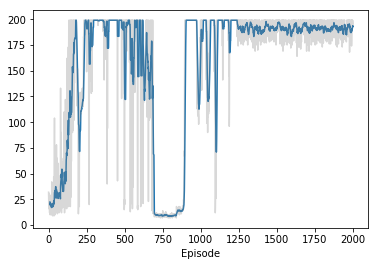

In [19]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0.5,0,'Episode')

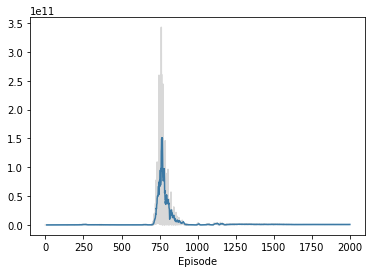

In [20]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
# plt.ylabel('Q losses')

In [21]:
# eps, arr = np.array(mean_qs_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# # plt.ylabel('Q losses')

In [22]:
# eps, arr = np.array(std_qs_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# # plt.ylabel('Q losses')

In [23]:
# eps, arr = np.array(mean_Qs_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# # plt.ylabel('Q losses')

In [24]:
# eps, arr = np.array(std_Qs_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# # plt.ylabel('Q losses')

In [25]:
# eps, arr = np.array(mean_nextQs_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# # plt.ylabel('Q losses')

In [26]:
# eps, arr = np.array(std_nextQs_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# # plt.ylabel('Q losses')

## Testing

Let's checkout how our trained agent plays the game.

In [25]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/QGAN-cartpole.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [26]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.